In [204]:
import pandas as pd
import numpy as np
import math
from scipy import stats
from datetime import date, datetime

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)
#Plot Styles
sns.set_style('whitegrid')
%matplotlib inline
plt.rcParams.update({'font.size': 16,
                     'xtick.labelsize' : 13,
                     'ytick.labelsize' : 13})

In [185]:
raw = pd.read_csv('data/openpowerlifting.csv')
meets = pd.read_csv('data/meets.csv')

In [157]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386414 entries, 0 to 386413
Data columns (total 17 columns):
MeetID            386414 non-null int64
Name              386414 non-null object
Sex               386414 non-null object
Equipment         386414 non-null object
Age               147147 non-null float64
Division          370571 non-null object
BodyweightKg      384012 non-null float64
WeightClassKg     382602 non-null object
Squat4Kg          1243 non-null float64
BestSquatKg       298071 non-null float64
Bench4Kg          1962 non-null float64
BestBenchKg       356364 non-null float64
Deadlift4Kg       2800 non-null float64
BestDeadliftKg    317847 non-null float64
TotalKg           363237 non-null float64
Place             385322 non-null object
Wilks             362194 non-null float64
dtypes: float64(10), int64(1), object(6)
memory usage: 50.1+ MB


# Data Cleaning

In [176]:
#The 4kg columns contain values for only a fraction of the rows, and don't offer much information in general - Drop
df = raw.drop(columns = ['Squat4Kg', 'Bench4Kg', 'Deadlift4Kg'])
df.drop_duplicates(inplace=True)
#df['Sex'] = df.Sex.map({'M':1, 'F':0})
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 385869 entries, 0 to 386413
Data columns (total 14 columns):
MeetID            385869 non-null int64
Name              385869 non-null object
Sex               385869 non-null object
Equipment         385869 non-null object
Age               147028 non-null float64
Division          370026 non-null object
BodyweightKg      383470 non-null float64
WeightClassKg     382062 non-null object
BestSquatKg       297905 non-null float64
BestBenchKg       355925 non-null float64
BestDeadliftKg    317447 non-null float64
TotalKg           362797 non-null float64
Place             384777 non-null object
Wilks             361754 non-null float64
dtypes: float64(7), int64(1), object(6)
memory usage: 44.2+ MB


None

,MeetID,Age,BodyweightKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Wilks
count,385869.000000,147028.000000,383470.000000,297905.000000,355925.000000,317447.000000,362797.000000,361754.000000
mean,5144.518326,31.665292,86.928824,176.551997,118.336628,195.038527,424.060625,301.134531
std,2551.532044,12.898242,23.138102,69.190264,54.843991,61.567345,196.317720,116.333631
min,0.000000,5.000000,15.880000,-477.500000,-522.500000,-410.000000,11.000000,13.730000
25%,2990.000000,22.000000,70.300000,127.500000,79.380000,147.500000,272.500000,237.570000
50%,5961.000000,28.000000,83.190000,174.630000,115.000000,195.000000,424.110000,319.720000
75%,7176.000000,39.000000,100.000000,217.720000,150.000000,238.140000,565.000000,379.320000
max,8481.000000,95.000000,242.400000,573.790000,488.500000,460.400000,1365.310000,779.380000


In [175]:
#One of the common competitions in powerlifting is BenchOnly, let's seperate out these entries before dropping NaNs
benchonly = df[(df.BestSquatKg.isna())&(df.BestDeadliftKg.isna())&(df.BestBenchKg>0)].drop(columns=['BestSquatKg', 'BestDeadliftKg'])
benchonly.head()

,Unnamed: 0,MeetID,Name,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,BestBenchKg,TotalKg,Place,Wilks,age_nan


In [160]:
#Alot of missing age values, instead of just dropping them, I'll add a column to denote if the item was nan and set the age value to 0.
def is_na(item):
    if np.isnan(item):
        return 1
    else:
        return 0
    
display(df.Age.isna().value_counts())
df['age_nan'] = 0
df['age_nan'] = df.Age.apply(lambda x: is_na(x))
df['Age'] = df.Age.fillna(0)
df.head()

True     238841
False    147028
Name: Age, dtype: int64

,MeetID,Name,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Place,Wilks,age_nan
0,0,Angie Belk Terry,F,Wraps,47.0,Mst 45-49,59.60,60,47.63,20.41,70.31,138.35,1,155.05,0
1,0,Dawn Bogart,F,Single-ply,42.0,Mst 40-44,58.51,60,142.88,95.25,163.29,401.42,1,456.38,0
2,0,Dawn Bogart,F,Single-ply,42.0,Open Senior,58.51,60,142.88,95.25,163.29,401.42,1,456.38,0
3,0,Dawn Bogart,F,Raw,42.0,Open Senior,58.51,60,NaN,95.25,NaN,95.25,1,108.29,0
4,0,Destiny Dula,F,Raw,18.0,Teen 18-19,63.68,67.5,NaN,31.75,90.72,122.47,1,130.47,0


In [161]:
df.Division.isna().value_counts()
df.Division.fillna('NA', inplace=True)

df['WeightClassKg'] = df.WeightClassKg.str.replace('+', '').astype(float)
wc_idx = df.loc[df.WeightClassKg.isna()].index
df.drop(index=wc_idx, inplace=True)
df['BodyweightKg'] = df.BodyweightKg.astype(float)

df = df.reset_index().drop(columns='index')

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382062 entries, 0 to 382061
Data columns (total 15 columns):
MeetID            382062 non-null int64
Name              382062 non-null object
Sex               382062 non-null object
Equipment         382062 non-null object
Age               382062 non-null float64
Division          382062 non-null object
BodyweightKg      381062 non-null float64
WeightClassKg     382062 non-null float64
BestSquatKg       295987 non-null float64
BestBenchKg       353612 non-null float64
BestDeadliftKg    315319 non-null float64
TotalKg           360378 non-null float64
Place             381059 non-null object
Wilks             359507 non-null float64
age_nan           382062 non-null int64
dtypes: float64(8), int64(2), object(5)
memory usage: 43.7+ MB


In [163]:
#Competitors often try to max out their weights within a specific weight class
#Set missing bodyweight values as the corresponding weight class value
bw_idx = df.loc[df.BodyweightKg.isna()].index
for idx in bw_idx:
    df.BodyweightKg.iloc[idx] = df.WeightClassKg.iloc[idx]

df.BodyweightKg.isna().value_counts()

C:\Users\JChaotogo\Anaconda\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



False    382062
Name: BodyweightKg, dtype: int64

In [164]:
#Fill the rest with 0 and then extract values greater than 0 for the important columns
df = df.fillna(0)
df = df[(df.BestSquatKg>0)&(df.BestBenchKg>0)&(df.BestDeadliftKg>0)&(df.TotalKg>0)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284237 entries, 0 to 382032
Data columns (total 15 columns):
MeetID            284237 non-null int64
Name              284237 non-null object
Sex               284237 non-null object
Equipment         284237 non-null object
Age               284237 non-null float64
Division          284237 non-null object
BodyweightKg      284237 non-null float64
WeightClassKg     284237 non-null float64
BestSquatKg       284237 non-null float64
BestBenchKg       284237 non-null float64
BestDeadliftKg    284237 non-null float64
TotalKg           284237 non-null float64
Place             284237 non-null object
Wilks             284237 non-null float64
age_nan           284237 non-null int64
dtypes: float64(8), int64(2), object(5)
memory usage: 34.7+ MB


In [166]:
df.to_csv('data/powerlifting_clean.csv')

In [177]:
df = pd.read_csv('data/powerlifting_clean.csv')

# EDA

Text(0.5, 1.0, 'Gender Counts')

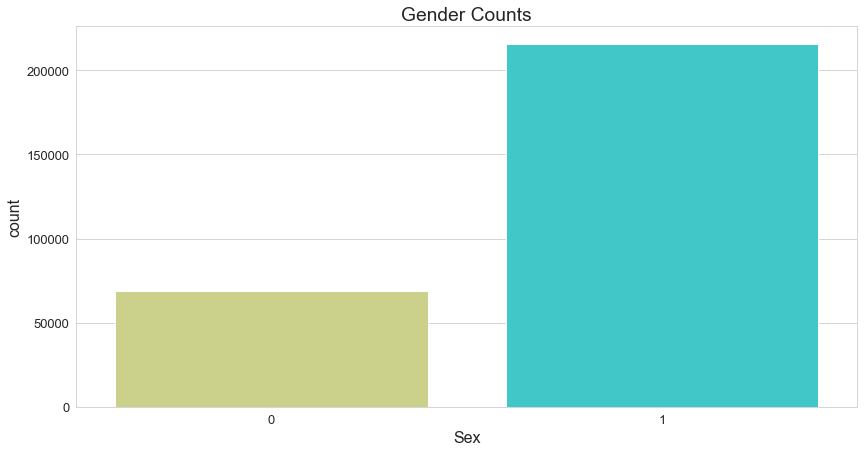

In [114]:
#What is the gender distribution of competitors?
plt.figure(figsize=(14,7))
sns.countplot(x='Sex', data=df, palette='rainbow_r')
plt.title('Gender Counts')

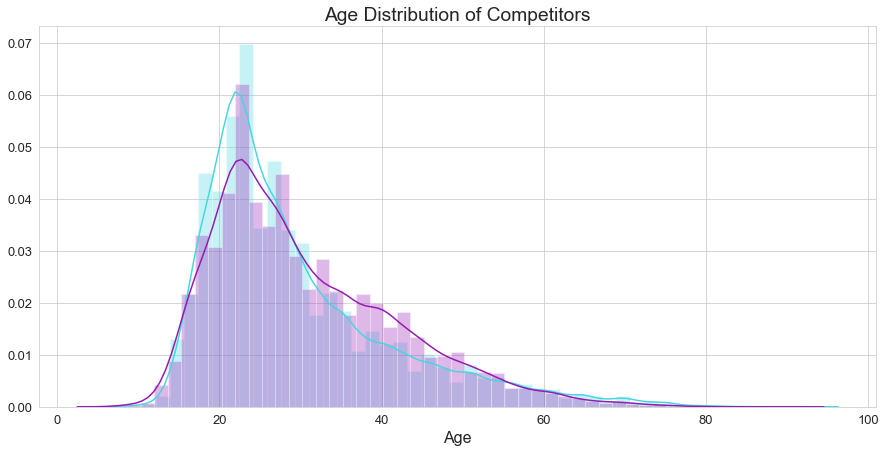

In [78]:
colors = ['#47d6e0', '#941ab2']

plt.figure(figsize=(15,7))
sns.distplot(df[(df.Sex==1)&(df.Age>0)]['Age'], color=colors[0], label='M', hist_kws=dict(alpha=.3))
sns.distplot(df[(df.Sex==0)&(df.Age>0)]['Age'], color=colors[1], label='F', hist_kws=dict(alpha=.3))
plt.title('Age Distribution of Competitors')
plt.show()

C:\Users\JChaotogo\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



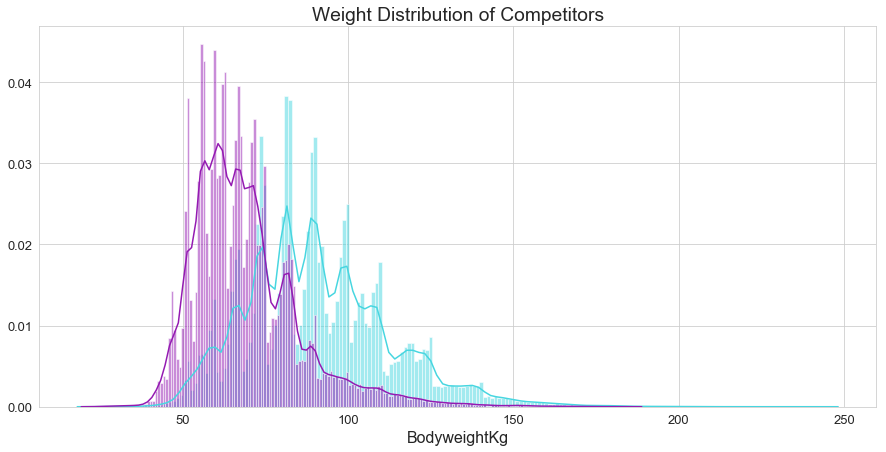

In [81]:
plt.figure(figsize=(15,7))
sns.distplot(df[(df.Sex==1)]['BodyweightKg'], color=colors[0], label='M', hist_kws=dict(alpha=.5), bins=200)
sns.distplot(df[(df.Sex==0)]['BodyweightKg'], color=colors[1], label='F', hist_kws=dict(alpha=.5), bins=200)
plt.title('Weight Distribution of Competitors')
plt.show()

The above graph is quite interesting looking. The frequency of weights seems to increase to certain intervals. This is likely explained by the fact that competitions are scored by weight classes, so competitors choose to maximize their weight within a weight class in order to acheive better placings. We will explore the effect that bodyweight has on strength soon.

Decreasing the number of bins shown creates a normal histogram.

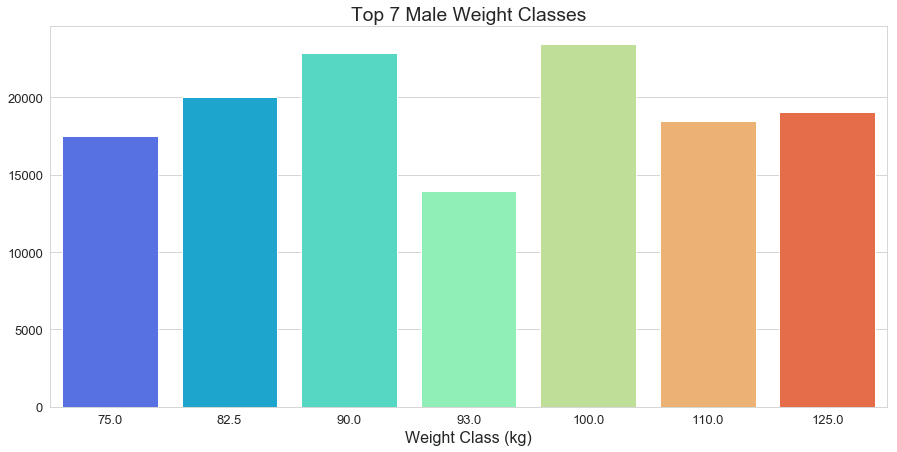

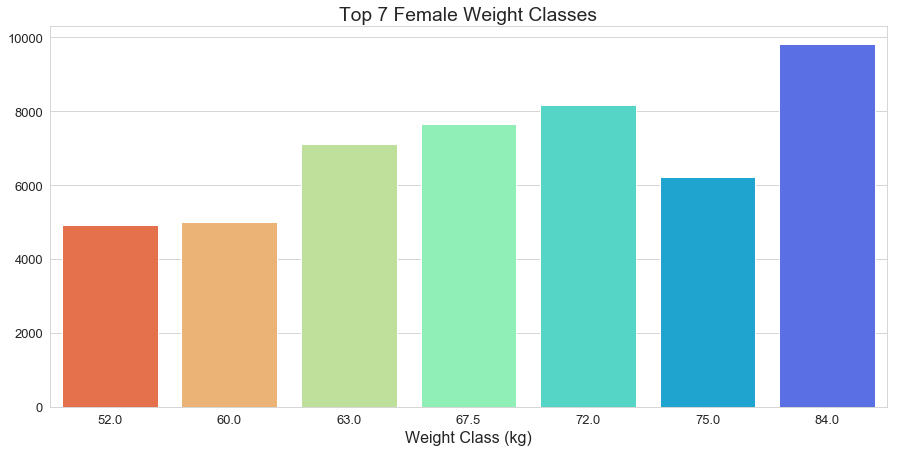

In [122]:
plt.figure(figsize=(15,7))
sns.barplot(x=df[df.Sex==1]['WeightClassKg'].value_counts(ascending=False).head(7).index,
            y=df[df.Sex==1]['WeightClassKg'].value_counts(ascending=False).head(7).values,
            palette='rainbow')
plt.title('Top 7 Male Weight Classes')
plt.xlabel('Weight Class (kg)')
plt.show()

plt.figure(figsize=(15,7))
sns.barplot(x=df[df.Sex==0]['WeightClassKg'].value_counts(ascending=False).head(7).index,
            y=df[df.Sex==0]['WeightClassKg'].value_counts(ascending=False).head(7).values,
            palette='rainbow_r')
plt.title('Top 7 Female Weight Classes')
plt.xlabel('Weight Class (kg)')
plt.show()

### Analysis of equipment's effect on performance

There are 4 categories for equipment that competitors use. Does the equipment used have an effect the performance of any of the lifts?

In [130]:
def plot_equip(column):
    plt.figure(figsize=(15,5))
    sns.lmplot(x='BodyweightKg', y=column, data=df, hue='Equipment', 
               scatter_kws={'alpha':0.3}, height=10, aspect=2.5, palette='pastel')
    plt.title(f'{column} vs Bodyweight')
    plt.xlabel('Bodyweight (kg)')
    plt.ylabel(f'{column} (kg)')
    plt.show()

<Figure size 1080x360 with 0 Axes>

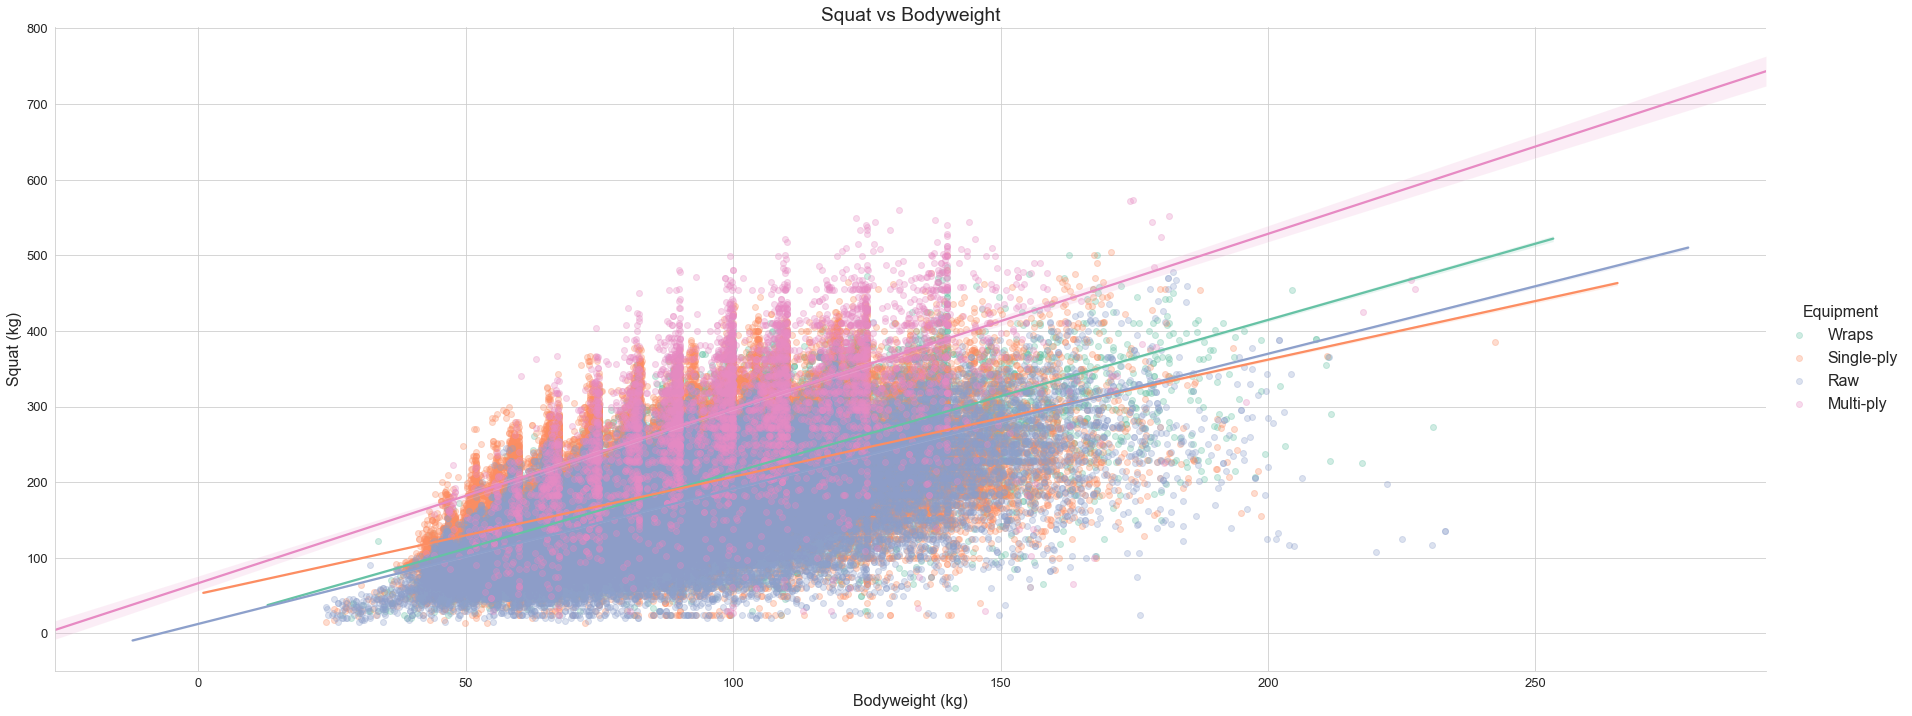

In [129]:
plt.figure(figsize=(15,5))
sns.lmplot(x='BodyweightKg', y='BestSquatKg', data=df, hue='Equipment', 
           scatter_kws={'alpha':0.3}, height=10, aspect=2.5, palette='Set2')
plt.title('Squat vs Bodyweight')
plt.xlabel('Bodyweight (kg)')
plt.ylabel('Squat (kg)')
plt.show()

C:\Users\JChaotogo\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



<Figure size 1080x360 with 0 Axes>

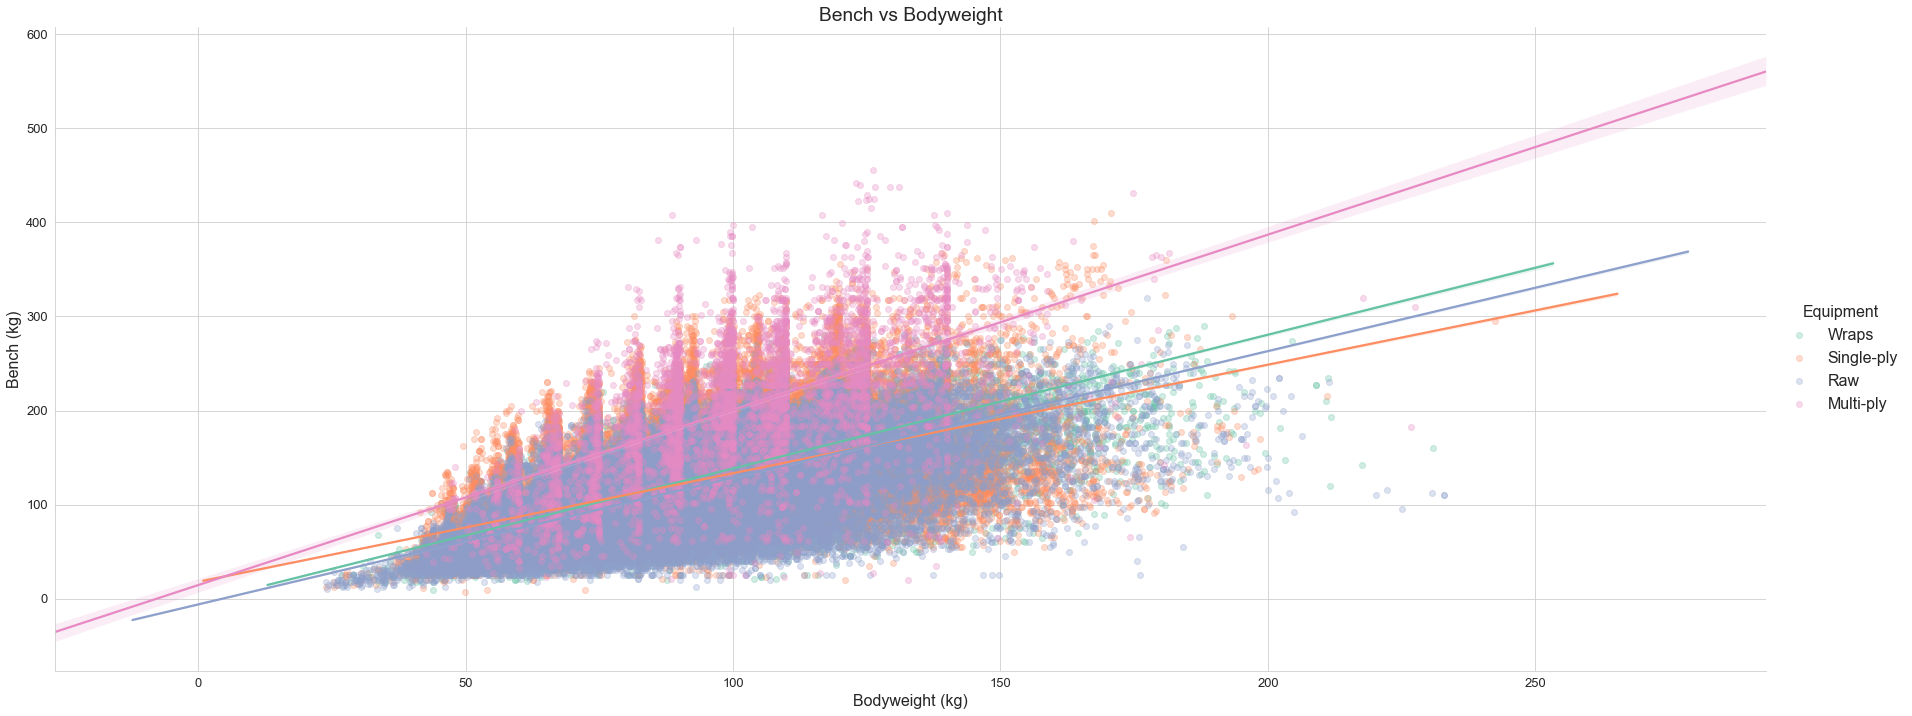

In [131]:
plt.figure(figsize=(15,5))
sns.lmplot(x='BodyweightKg', y='BestBenchKg', data=df, hue='Equipment', 
           scatter_kws={'alpha':0.3}, height=10, aspect=2.5, palette='Set2')
plt.title('Bench vs Bodyweight')
plt.xlabel('Bodyweight (kg)')
plt.ylabel('Bench (kg)')
plt.show()

<Figure size 1080x360 with 0 Axes>

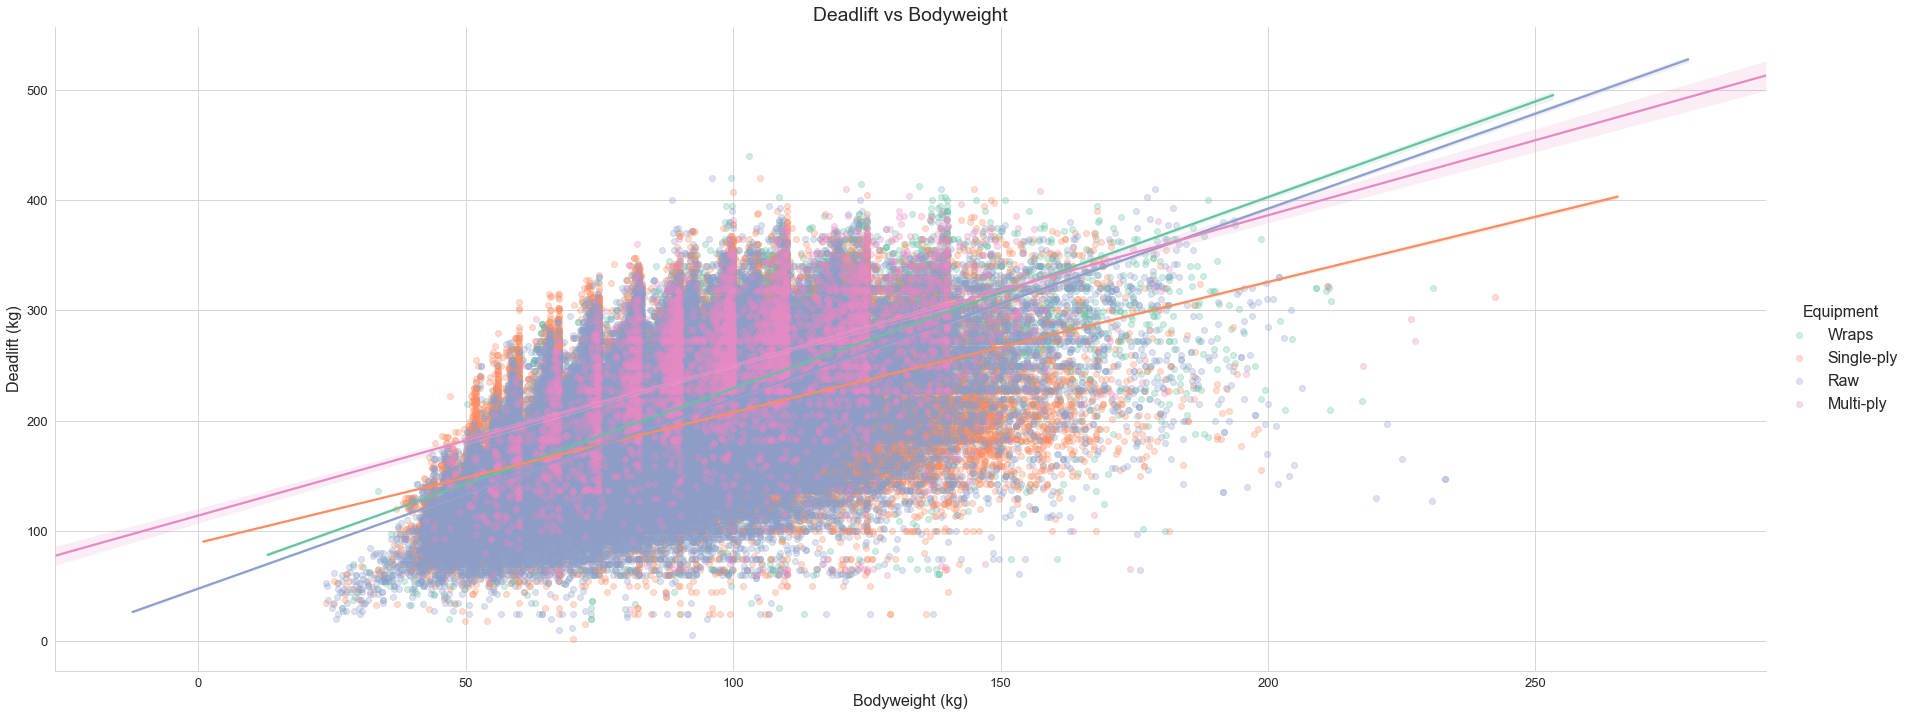

In [132]:
plt.figure(figsize=(15,5))
sns.lmplot(x='BodyweightKg', y='BestDeadliftKg', data=df, hue='Equipment', 
           scatter_kws={'alpha':0.3}, height=10, aspect=2.5, palette='Set2')
plt.title('Deadlift vs Bodyweight')
plt.xlabel('Bodyweight (kg)')
plt.ylabel('Deadlift (kg)')
plt.show()

<Figure size 1080x360 with 0 Axes>

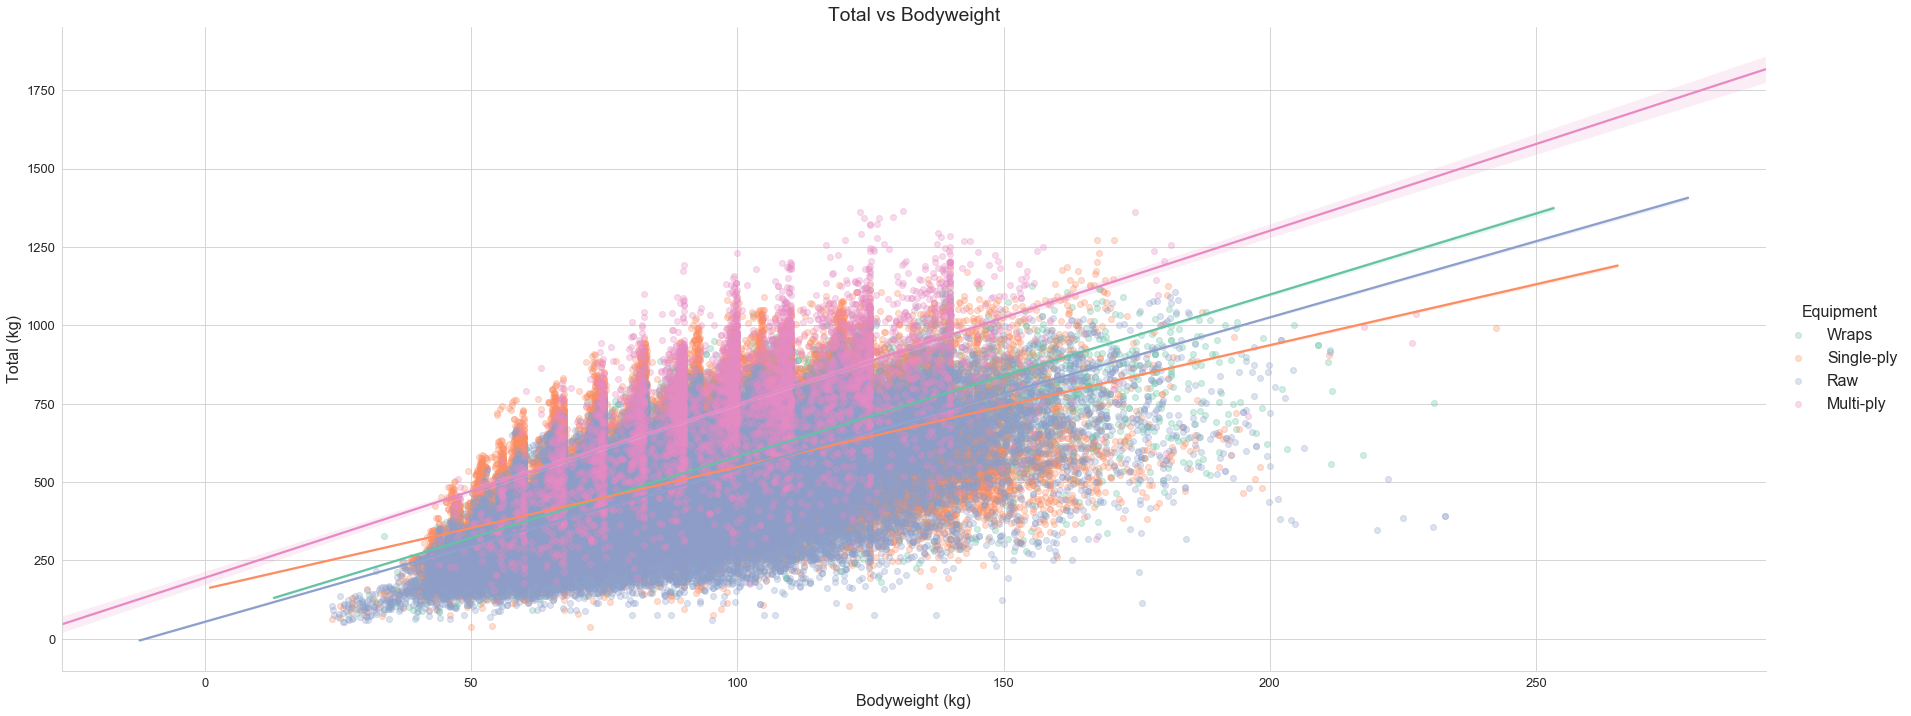

In [133]:
plt.figure(figsize=(15,5))
sns.lmplot(x='BodyweightKg', y='TotalKg', data=df, hue='Equipment', 
           scatter_kws={'alpha':0.3}, height=10, aspect=2.5, palette='Set2')
plt.title('Total vs Bodyweight')
plt.xlabel('Bodyweight (kg)')
plt.ylabel('Total (kg)')
plt.show()

Multi-ply equipment has a strong correlation with higher lifts. This is possibly due to the added support that a thick jumper provides a competitor. Having tried one before, I found that multi-ply jumpers increased the amount I was able to lift by upwards of 20%. The material acts as a spring and likely helps store potential energy. In terms of performance, multi-ply is closely followed by wraps, raw, and single-ply.

Equipment performance in deadlifts stands out the most. Multi-ply is correlated with higher lift numbers for lower BestDeadliftKg and Bodyweight numbers, but is outperformed by both Raw and Wraps lifters. Further research into the mechanics of deadlifting compared to squatting and benching can help explain this. I suspect it is due to fact that energy cannot be stored in multi-ply equipment when pulling a weight from the ground.

### Average Total Lifts by Age

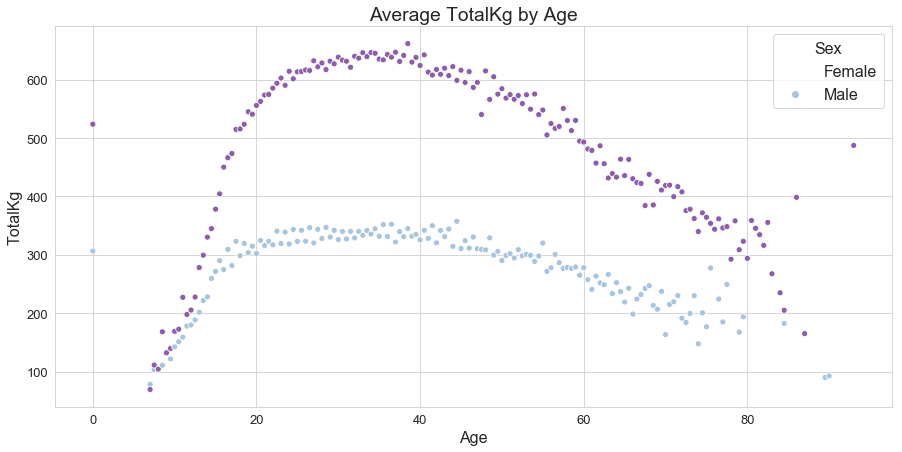

In [152]:
liftage = df.groupby(['Age', 'Sex'], as_index=False).agg(np.mean)

plt.figure(figsize=(15,7))
sns.scatterplot(x='Age', y='TotalKg', data=liftage, hue='Sex', palette='BuPu')
plt.title('Average TotalKg by Age')
plt.show()

The chart above shows the mean total lifts of men and women by age. Male competitors on average have peak lifts from ages 25-40. Lifters older than 40 have a sharp decline in their total lifts. Female competitors on average have peak lifts from ages 20-40. Older female competitor's total lifts drop off after age 40 but at a much more level rate.

### Wilks Score Relationship to Total Lifts

<Figure size 1080x360 with 0 Axes>

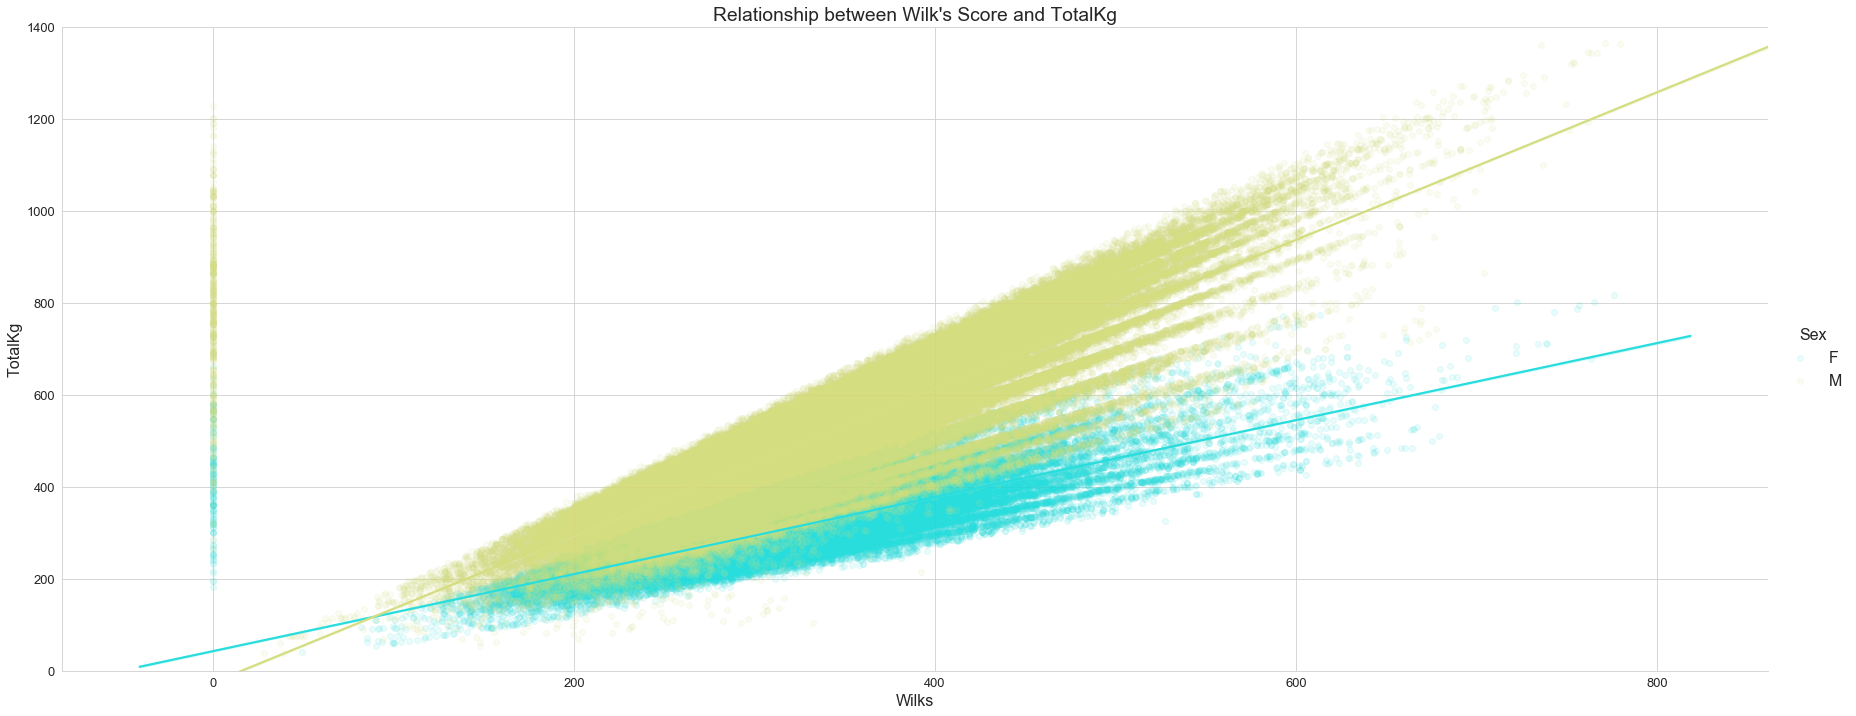

In [170]:
#Scatter plot of relationship between Wilks and TotalKg seperated by sex.
plt.figure(figsize=(15,5))
sns.lmplot(x='Wilks', y='TotalKg', data=df[df.TotalKg>0], hue='Sex', 
           scatter=True, scatter_kws={'alpha':0.1}, palette='rainbow',height=10, aspect=2.5)
plt.title("Relationship between Wilk's Score and TotalKg")
plt.ylim(0, 1400)
plt.show()

The Wilk's score is a measure of a powerlifter's strength taking into account weight, age, and gender. Above, I took the mean TotalKg for each corresponding Wilk's score. As expected, we get a positive linear relationship between a competitor's Wilk's score and the competitors total lifts. 

Surprisingly however, the slopes of TotalKg/Wilks for men is significantly higher than for women. Wilk's score is supposed to take into account gender, and ideally the TotalKg/Wilks ratio should be equal between men and women. It looks like there is a systematic error in calculating Wilk's score. One possible explanation could be that the scores were self-reported, with men over-reporting their numbers.

In [178]:
meets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8482 entries, 0 to 8481
Data columns (total 8 columns):
MeetID         8482 non-null int64
MeetPath       8482 non-null object
Federation     8482 non-null object
Date           8482 non-null object
MeetCountry    8482 non-null object
MeetState      5496 non-null object
MeetTown       6973 non-null object
MeetName       8482 non-null object
dtypes: int64(1), object(7)
memory usage: 530.2+ KB


In [188]:
meets.MeetCountry.value_counts()

USA                  3894
Norway               2521
Canada               1066
Australia             532
New Zealand           195
UK                     75
Russia                 43
Ireland                21
England                16
Finland                16
Czechia                12
Spain                   8
South Africa            8
Serbia                  7
France                  6
Italy                   6
India                   5
Sweden                  4
Estonia                 4
Ukraine                 4
US Virgin Islands       3
Belarus                 3
Colombia                3
Poland                  3
Germany                 3
Brazil                  3
Puerto Rico             2
Luxembourg              2
Denmark                 2
Greece                  2
Kazakhstan              2
New Caledonia           1
Israel                  1
Indonesia               1
Singapore               1
Malaysia                1
Iceland                 1
Cayman Islands          1
Japan       

In [196]:
#N.Ireland, Scotland, and Wales are all part of UK
def uk_edit(item):
    uk_countries = ['N.Ireland', 'Scotland', 'Wales', 'England']
    if item in uk_countries:
        return 'UK'
    else:
        return item
    
meets['MeetCountry'] = meets.MeetCountry.apply(lambda x: uk_edit(x))
meets.MeetCountry.value_counts().head(10)

USA            3894
Norway         2521
Canada         1066
Australia       532
New Zealand     195
UK               91
Russia           43
Ireland          21
Finland          16
Czechia          12
Name: MeetCountry, dtype: int64

### Analysis of meet locations over the years

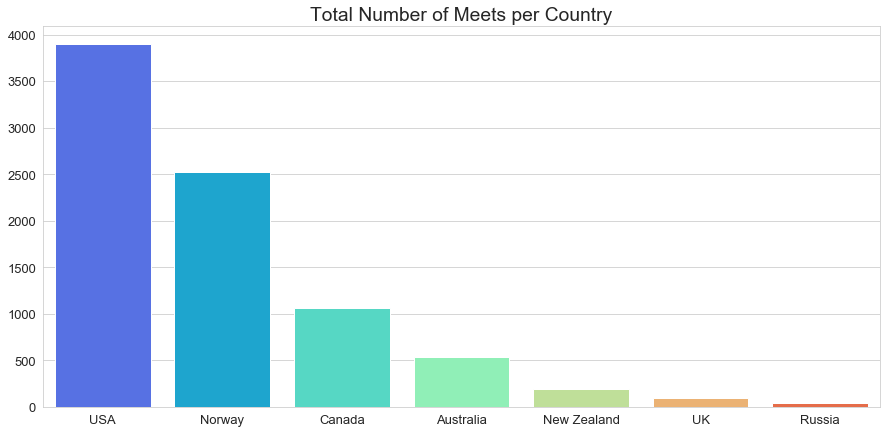

In [328]:
plt.figure(figsize=(15,7))
sns.barplot(x=meets.MeetCountry.value_counts().head(7).index,
            y=meets.MeetCountry.value_counts().head(7).values,
            palette='rainbow')
plt.title('Total Number of Meets per Country')
plt.show()

USA has the greatest number of meets, but also has the largest population in the top 7. Let's find the number of meets per capita. To do this, I'm going to join historic data on population to the meets table.

In [208]:
meets['Date'] = pd.to_datetime(meets.Date)
meets['Year'] = meets.Date.apply(lambda x: x.year)
meets['Month']= meets.Date.apply(lambda x: x.month)
meets['Day']= meets.Date.apply(lambda x: x.day)

#### Historical Population Data
I obtained historical population data from fred.stlouisfed.org. They offer tons economic and demographic information on most countries. Reading them in as CSVs will allow me to match the populations to corresponding years and countries.

In [350]:
usapop = pd.read_csv('data/USAPOP.csv')
norpop = pd.read_csv('data/NORWAYPOP.csv')
canpop = pd.read_csv('data/CANPOP.csv')
auspop = pd.read_csv('data/AUSPOP.csv')
nzpop = pd.read_csv('data/NZPOP.csv')
ukpop = pd.read_csv('data/UKPOP.csv')
ruspop = pd.read_csv('data/RUSPOP.csv')

cpop = [usapop, norpop, canpop, auspop, nzpop, ukpop, ruspop]
cnames = meets.MeetCountry.value_counts().head(7).index
cdict = dict(zip(cnames, cpop))

for frame in cpop:
    frame['DATE'] = pd.to_datetime(frame.DATE)
    frame['Year'] = frame.DATE.apply(lambda x: x.year)

cnames = meets.MeetCountry.value_counts().head(7).index
cdict = dict(zip(cnames, cpop))

for name in cnames:
    cdict[name]['MeetCountry'] = name
    
populations = pd.concat(cdict.values(), ignore_index=True)

In [351]:
pc = meets.groupby(['Year', 'MeetCountry']).count()
pop = pd.merge(pc, populations[['MeetCountry', 'Year', 'POP']], on=['MeetCountry', 'Year'], how='left')
pop['meets_per_million'] = pop['MeetID']/(pop['POP']/1000000)
pop.dropna(inplace=True)
pop=pop.sort_values('meets_per_million')

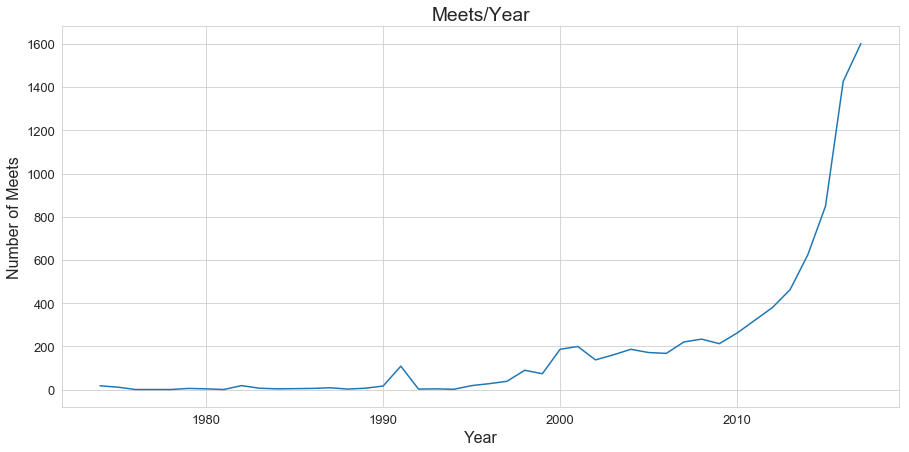

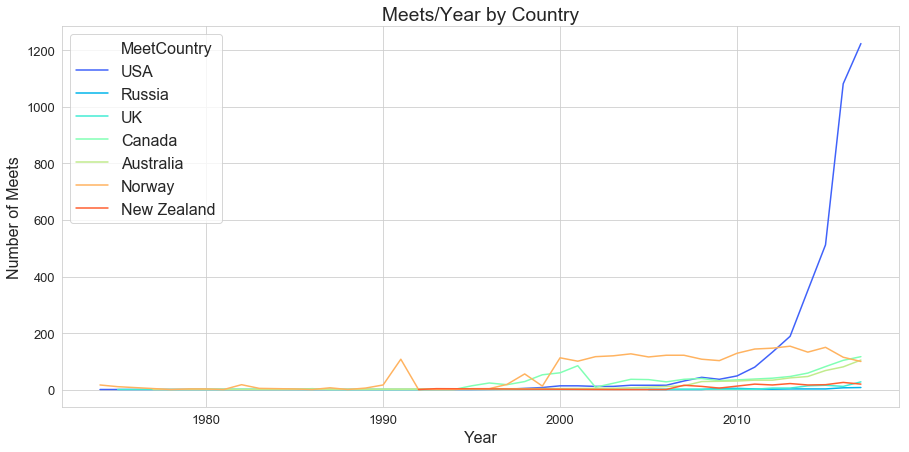

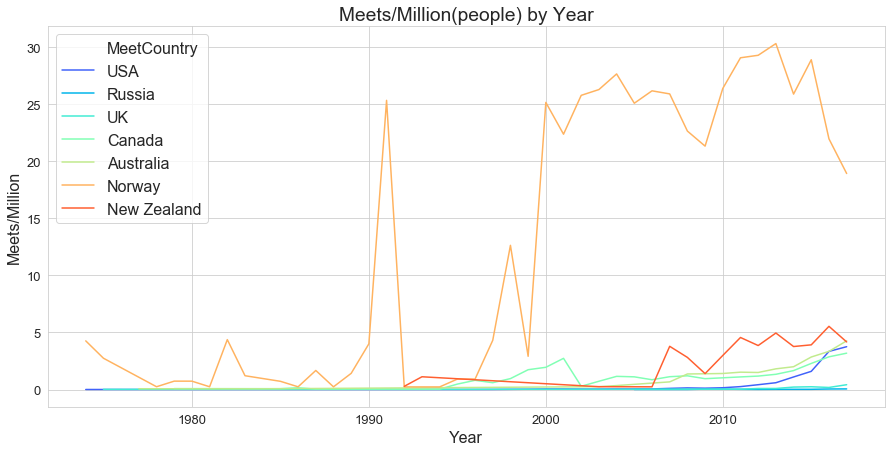

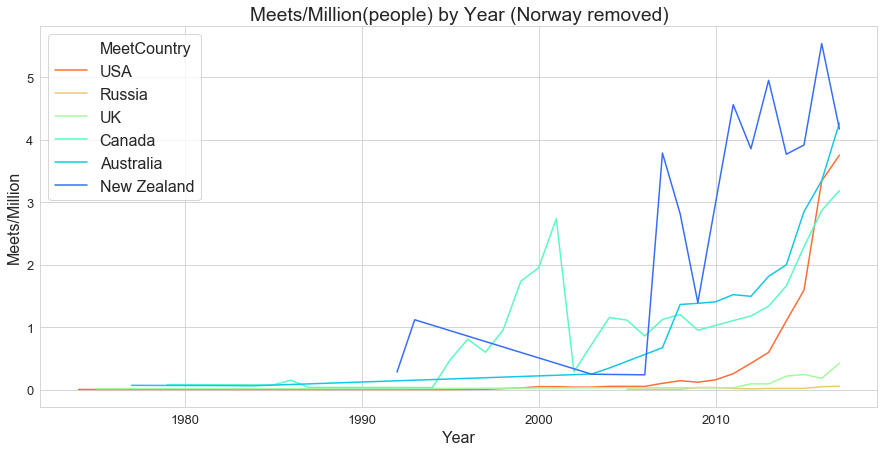

In [352]:
#We are only looking at years before 2018 because it looks like the data was collected before 2018 was finished.
plot1 = pop[pop.Year<2018].groupby('Year', as_index=False).agg(np.sum) #Total Number of meets per year

plt.figure(figsize=(15,7))
sns.lineplot(x='Year', y='MeetID', data=plot1)
plt.title('Meets/Year')
plt.ylabel('Number of Meets')
plt.show()

plt.figure(figsize=(15,7))
sns.lineplot(x='Year', y='MeetID', hue='MeetCountry', 
             data=pop[(pop.Year<2018)], palette='rainbow')
plt.title('Meets/Year by Country')
plt.ylabel('Number of Meets')
plt.show()

plt.figure(figsize=(15,7))
sns.lineplot(x='Year', y='meets_per_million', hue='MeetCountry', 
             data=pop[(pop.Year<2018)], palette='rainbow')
plt.title('Meets/Million(people) by Year')
plt.ylabel('Meets/Million')
plt.show()

plt.figure(figsize=(15,7))
sns.lineplot(x='Year', y='meets_per_million', hue='MeetCountry', 
             data=pop[(pop.MeetCountry!='Norway')&(pop.Year<2018)], palette='rainbow_r')
plt.title('Meets/Million(people) by Year (Norway removed)')
plt.ylabel('Meets/Million')
plt.show()

The number of meets held per year is growing at an exponential rate which shows an explosion in popularity of the powerlifting sport. When broken down by country, we see that USA hosts the most meets per year; the number is still growing. However, if we take into account the populations of the countries, we see that Norway hosts far more meets per capita. USA, New Zealand, Australia, and Canada host roughly the same number of meets per capita per year.